In [1]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import plotly.offline as off
import nltk
from nltk.corpus import wordnet
import numpy as np
import json
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
meta = pd.read_csv('movies_metadata.csv')
keywords = pd.read_csv('keywords.csv')
ratings = pd.read_csv('ratings_small.csv')

/Users/rahulshiv/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
#this function does imputation for the passed columns using the given regressor
def reg_fill(df, column, regressor):
    ndf = df.dropna(subset=[col for col in df.columns if col != column])
    ndf.loc[ndf[column]<5000,column]=None
    nullmask = ndf[column].isnull()
    train, test  = ndf[~nullmask], ndf[nullmask]
    train_x, train_y = train.drop(column, axis=1), train[column]
    regressor.fit(train_x, train_y)
    if len(test) > 0:
        test_x, test_y = test.drop(column, axis=1), test[column]
        values = regressor.predict(test_x)
        test_y = pd.Series(values)
        test_y.index = test.index
        new_x, new_y = pd.concat([train_x, test_x]), pd.concat([train_y, test_y])
        return new_y
    else:
        return ndf[column]

#this function counts occurences of words in the required column
def count_word(df, ref_col, list_):
    keyword_count = dict()
    for s in list_: keyword_count[s] = 0
    for list_keywords in df[ref_col]:        
        if type(list_keywords) == float and pd.isnull(list_keywords): continue        
        for s in [s for s in list_keywords if s in list_]: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

#this function converts a column to a required format
def convert(task):
    temp_dict = dict()
    temp_arr = []
    temp_series = meta[task]
    for item in temp_series:
        if type(item) != type(str()):
            continue
        t = literal_eval(item)
        if type(t)!=type([]):
            continue
        temp =[]
        for i in t:
            temp.append(i['name'])
            if str(i['name']) not in temp_dict.keys():
                temp_dict[str(i['name'])] = 1
            else:
                temp_dict[str(i['name'])]+=1
        temp_arr.append(temp)
    meta[task]=pd.Series(temp_arr)
    return temp_dict

#replaces keywords by their lemmas or just by the keywords provided in the dictionary
def replacement_df_keywords(df, dict_repl, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chain = row['keywords']
        if type(chain) == type(0.0) : continue
        temp = []
        for s in chain: 
            key = PS.lemmatize(s) if roots else s
            if key in dict_repl.keys():
                temp.append(dict_repl[key])
            else:
                temp.append(s) if roots else temp.append(s)       
        df_new.at[index, 'keywords'] = temp
    return df_new

#creates inventory of keywords nececessary for further processing
def keywords_inventory(dataframe, column = 'keywords'):
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[column]:
        if type(s) == type(0.0) : continue
        for t in s:
            t = t.lower()
            root = PS.lemmatize(t)
            if root in keywords_roots:    
                 keywords_roots[root].add(t)
            else:
                keywords_roots[root]={t}
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    key = k ; min_length = len(k)            
            category_keys.append(key)
            keywords_select[s] = key
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    return category_keys, keywords_roots, keywords_select

#gets synonyms of the word passed to it
def get_synonyms(word_key):
    lemma = set()
    for ss in wordnet.synsets(word_key):
        for w in ss.lemma_names():
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

#checks if count of a keywords is greater than a threshold
def test_keyword(word, key_count, threshold):
    return (False , True)[key_count.get(word, 0) >= threshold]

#transforms genre column to a dictionary form required for further pre-processing
def genre_transform():
    temp_dict = dict()
    for index,row in meta.iterrows():
        movies_list.append(tuple([row.release_date.year,row.revenue]))
        for i in row.genres:
            if str(i) not in temp_dict.keys():
                temp_dict[str(i)] = [tuple([row.release_date.year,row.revenue])]
            else:
                temp_dict[str(i)].append(tuple([row.release_date.year,row.revenue]))
    return temp_dict

def convert_key():
    temp = ""
    temp_series = df_keywords_synonyms['keywords']
    for item in temp_series:
        if type(item)!=type([]):
            continue
        for i in item:
            temp = temp + i
    return temp

In [4]:
#this cell drops unnecessary columns, converts the remaining to the required datatype and drops NaNs
#a left join of meta and keywords dataset is done on id
#this cell also includes the imputation of revenue and budget columns
PS = nltk.stem.WordNetLemmatizer()

off.init_notebook_mode(connected=True)


ratings = ratings.rename(columns={'movieId':'id'})
#Convert IDs to numeric from string
meta = meta[meta.status=="Released"]
meta.id = pd.to_numeric(meta.id,errors="coerce")
meta.budget = pd.to_numeric(meta.budget,errors="coerce")
meta = meta.dropna(subset=["id"])
meta.loc[:,'release_date']=pd.to_datetime(meta.release_date, format = '%Y-%m-%d', errors="coerce")
meta = meta.dropna(subset=["release_date"])
meta = meta.drop_duplicates(subset=['id'])
meta = meta.drop(['adult','belongs_to_collection','status','tagline','homepage','poster_path','production_countries','video','spoken_languages','original_title'], axis =1)

keywords = keywords[keywords.keywords!="[]"]
keywords = keywords.drop_duplicates(subset=['id'])
meta = pd.merge(meta,
                 keywords,
                 on='id',how='left')

tab_info=pd.DataFrame(meta.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(meta.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(meta.isnull().sum()/meta.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))


meta.popularity = pd.to_numeric(meta.popularity, errors='coerce')
meta = meta.dropna(subset=[col for col in meta.columns[[0,5,8,9,11,12]]])
tasks = ['genres','production_companies','keywords']

impute_order = ['budget','revenue']
for col in impute_order:
    meta.loc[:,col] = reg_fill(meta.loc[:,['budget','popularity','revenue','runtime','vote_average','vote_count']], col,  KNeighborsRegressor())

In [5]:
#in this cell we do keyword preprocessing by replacing them with the most occurring synonyms and then applying lemmatization

keyword_dict = convert('keywords')

df_2 = meta

icount = 0
for index, row in meta[meta['keywords'].isnull()].iterrows():
    icount += 1
    word_list = row['title'].strip().split()
    new_keyword = []
    for s in word_list:
        lemma = get_synonyms(s)
        for t in list(lemma):
            if t in keyword_dict.keys(): 
                new_keyword.append(t)
    if new_keyword:
        meta.at[index, 'keywords'] = new_keyword

keywords_dat, keywords_roots, keywords_select = keywords_inventory(meta,
                                                               column = 'keywords')

df_keywords_cleaned = replacement_df_keywords(meta, keywords_select,
                                               roots = True)

keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'keywords',keywords_dat)

keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]

repl_word = dict()
icount = 0
for index, [word, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  
    lemma = get_synonyms(word)
    if len(lemma) == 0: continue  
    word_list = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[word])]
    word_list.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(word_list) <= 1: continue     
    if word == word_list[0][0]: continue
    repl_word[word] = word_list[0][0]

for key, value in repl_word.items():
    if value in repl_word.keys():
        repl_word[key] = repl_word[value]  
        
df_keywords_synonyms = replacement_df_keywords(df_keywords_cleaned, repl_word, roots = False)   

keywords_dat, keywords_roots, keywords_select = keywords_inventory(df_keywords_synonyms, column = 'keywords')

new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'keywords',keywords_dat)

movies_list = []

genre_plot_dict = genre_transform()


In [6]:
meta = df_keywords_synonyms

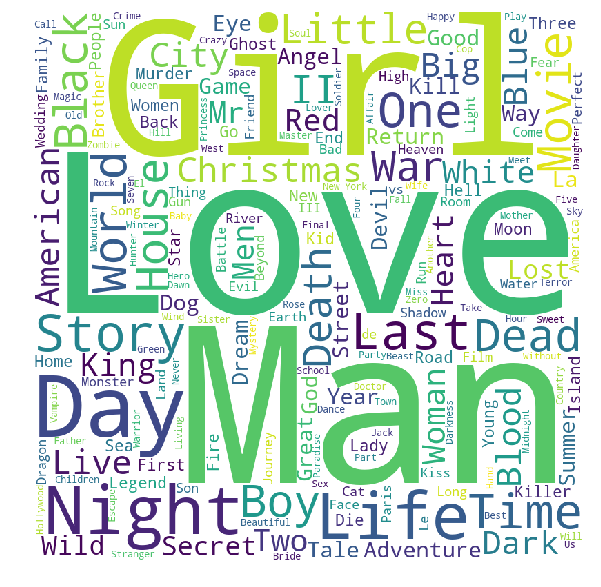

In [7]:
# Creating word cloud for title:
meta['title'] = meta['title'].astype(str)
title = ' '.join(meta['title'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(title)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

In [8]:
%store keyword_dict
%store new_keyword_occurences

Stored 'keyword_dict' (dict)
Stored 'new_keyword_occurences' (list)


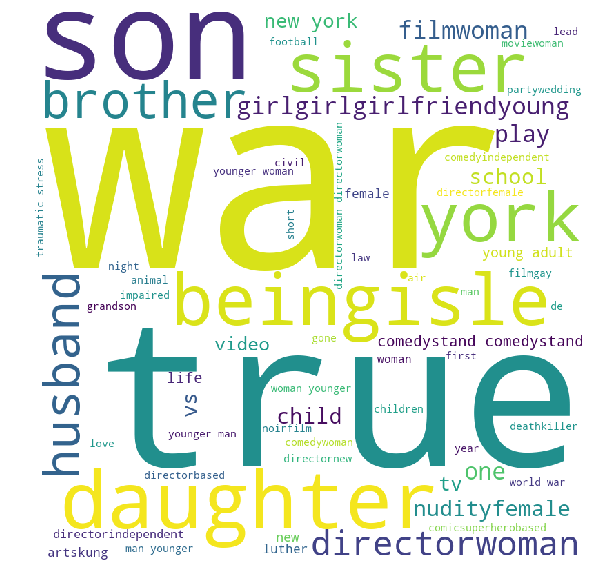

In [9]:
# Creating word cloud for keywords:
string = convert_key()

wordcloud_key = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(string)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_key) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

In [10]:
meta.to_csv("movies_metadata_preprocessed.csv",sep=",",index=False)
keywords.to_csv("keywords_preprocessed.csv",sep=",",index=False)
ratings.to_csv("ratings_preprocessed.csv",sep=",",index=False)